In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numba

from numba import prange

from plot_functions import plot_connections, plot_poblacion
from main_functions import generate_vecinos, generate_vecinos_int, generate_vecinos_array
from main_functions import init_poblacion, temperatura_critica


plt.style.use(['science', 'notebook'])

# Dinámica de contactos

Añadimos un grado de libertad más al sistema haciendo posible que un individuo no solo cambie la opinión si no que si no esta de acuerdo con alguno de sus contactos decida reemplazarlo con uno nuevo elegido al azar

## $\nu$

In [6]:
@numba.njit(parallel=True, nogil=True)
def metropolis_dinamico_int(lattice, steps, T, num):
    """ funcion realiza una simulacion de montecarlo del modelo 
        de ising utilizando el algoritmo de metropolis teniendo 
        en cuenta que ahora los vecinos se toman aleatoriamente
        - inputs: 
            - lattice: matrix NxN con elementos +-1
            - steps: pasos de montecarlo
            - T: temperatura del sistema
            - num: numero de vecinos de cada individuo
        - outputs: 
            - spins_sum: vector 1xsteps que contiene np.sum(lattice)
    """
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.zeros(steps)
    vecinos_dict = generate_vecinos_int(num, N)
    for step in prange(steps):
        # seleccionamos espin aleatorio para modificar contactos o para moificar espins
        x, y = np.random.randint(0, N, 2) 
        if step%2:
            spin_i = lattice[x, y]
            spin_f = -1*spin_i
            # calculo de la opinion de los 4 vecinos
            vecinos = vecinos_dict[x, y]
            # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
            # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
            S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
            # ver si se acepta el cambio
            if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
                # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
                # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
                # ponemos el valor absoluto para mantener el sentido del modelo de ising
                lattice[x, y] = spin_f
        else:
            vecinos_actuales = vecinos_dict[x, y]
            # choose random vecino to change
            num_vecinos = len(vecinos_actuales[0])
            change = np.random.randint(num_vecinos)
            x_change, y_change = vecinos_actuales[0][change], vecinos_actuales[1][change] 
            
            if lattice[x, y] * lattice[x_change, y_change] < 0:
                 # si no estan de acuerdo cambiamos ese vecino aleatoriamente
                x_f, y_f = np.random.randint(0, N, 2)
                while (x==x_f)*(y==y_f):
                    # evitar que se coja el mismo espin x0, y0
                    x_f, y_f = np.random.randint(0, N, 2)
                    
                # modificamos el diccionario de las conexiones
                vecinos_actuales[0][change] = x_f
                vecinos_actuales[1][change] = y_f
                vecinos_dict[x, y] = vecinos_actuales
                
        spins_sum[step] = np.sum(lattice)
            
    return spins_sum

In [7]:
@numba.njit(parallel=True, nogil=True)
def temperatura_critica_nu(N, prob, T_arr, nu_arr, steps):
    """ funcion que calcula la temperatura critica en funcion 
        del valor nu (vecinos por individuo)
        - inputs: 
            - N: tamaño de la red NxN
            - prob: probabilidad que define el sesgo de la poblacion
            - T_arr: array de temperaturas
            - nu_arr: array con los valores de nu
            - steps: pasos de montecarlo
        - outputs:
            - Tc_arr: array con las Tc por nu
    """
    pob_n = init_poblacion(N, prob)
    pob_p = - init_poblacion(N, prob)
    # prealocar t critic
    Tc_arr = np.empty(len(nu_arr))
    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))
    for n in range(len(nu_arr)):
        nu = nu_arr[n]
        print(nu, ' ok')
        for i in prange(len(T_arr)):
            T = T_arr[i]
            spins = metropolis_dinamico_int(pob_n, steps, T, nu)
            m_n[i] = np.mean(spins[-10000:])
            spins = metropolis_dinamico_int(pob_p, steps, T, nu)
            m_p[i] = np.mean(spins[-10000:])
        Tc_arr[n] = temperatura_critica(T_arr, m_p/N**2, m_n/N**2)
    return Tc_arr

In [63]:
%%time

N = 20
prob = 0.75
# pasos de montecarlo
steps = 200000
# array de temperaturas
T_arr = np.linspace(0.01, 10)
# numero de vecinos 1, 2, 3, nu_max
nu_arr = np.arange(1, 20+1)

Tc_arr = temperatura_critica_nu(N, prob, T_arr, nu_arr, steps)

1  ok
2  ok
3  ok
4  ok
5  ok
6  ok
7  ok
8  ok
9  ok
10  ok
11  ok
12  ok
13  ok
14  ok
15  ok
16  ok
17  ok
18  ok
19  ok
20  ok
CPU times: total: 13min 59s
Wall time: 2min 1s


In [64]:
print(np.max(Tc_arr))

8.878673469387754


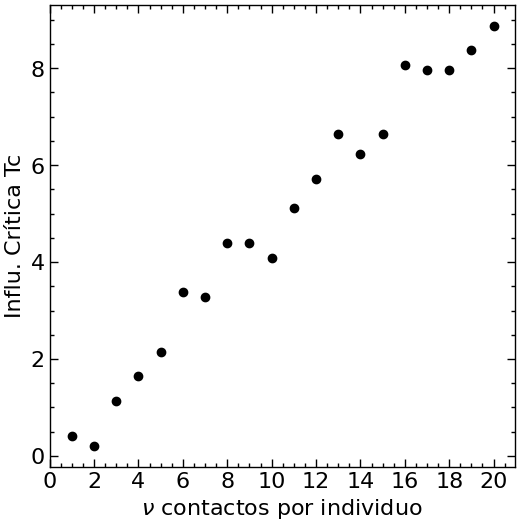

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(nu_arr, Tc_arr, 'ko')
ax.set_xticks(list(range(0, 20+2, 2)))
ax.set_xlabel(r'$\nu$ contactos por individuo')
ax.set_ylabel('Influ. Crítica Tc')
plt.show()

In [9]:
# fig.savefig('IMAGENES/T_N_nu_arr_din.png')

## Gauss

In [8]:
@numba.njit(parallel=True, nogil=True)
def metropolis_dinamico_array(lattice, steps, T, num):
    """ adaptacion de la funcion de metropolis definada 
        anteriormente para que reciba un num en forma de 
        matriz que contiene un numero particular de 
        contactos asociado a cada indiviudo
    """
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.zeros(steps)
    vecinos_dict = generate_vecinos_array(num, N)
    for step in prange(steps):
        # seleccionamos espin aleatorio para modificar contactos o para moificar espins
        x, y = np.random.randint(0, N, 2) 
        if step%2:
            spin_i = lattice[x, y]
            spin_f = -1*spin_i
            # calculo de la opinion de los 4 vecinos
            vecinos = vecinos_dict[x, y]
            # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
            # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
            S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
            # ver si se acepta el cambio
            if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
                # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
                # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
                # ponemos el valor absoluto para mantener el sentido del modelo de ising
                lattice[x, y] = spin_f
        else:
            vecinos_actuales = vecinos_dict[x, y]
            # choose random vecino to change
            num_vecinos = len(vecinos_actuales[0])
            change = np.random.randint(num_vecinos)
            x_change, y_change = vecinos_actuales[0][change], vecinos_actuales[1][change] 
            
            if lattice[x, y] * lattice[x_change, y_change] < 0:
                 # si no estan de acuerdo cambiamos ese vecino aleatoriamente
                x_f, y_f = np.random.randint(0, N, 2)
                while (x==x_f)*(y==y_f):
                    # evitar que se coja el mismo espin x0, y0
                    x_f, y_f = np.random.randint(0, N, 2)
                    
                # modificamos el diccionario de las conexiones
                vecinos_actuales[0][change] = x_f
                vecinos_actuales[1][change] = y_f
                vecinos_dict[x, y] = vecinos_actuales
                
        spins_sum[step] = np.sum(lattice)
            
    return spins_sum

In [9]:
@numba.njit(parallel=True, nogil=True)
def temperatura_critica_sigma(N, prob, T_arr, dist_lattice, steps):
    """ funcion que calcula la temperatura critica en funcion 
        del valor mu y sigma para una distribucion de contactos 
        por vecino gausiana
        - inputs: 
            - N: tamaño de la red NxN
            - prob: probabilidad que define el sesgo de la poblacion
            - T_arr: array de temperaturas
            - dist_lattice: array con contactos por individuo
            - steps: pasos de montecarlo
        - outputs:
            - Tc_arr: array con las Tc por nu
    """
    pob_n = init_poblacion(N, prob)
    pob_p = - pob_n.copy()

    
    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))

    for i in prange(len(T_arr)):
        T = T_arr[i]
        spins = metropolis_dinamico_array(pob_n, steps, T, dist_lattice)
        m_n[i] = np.mean(spins[-10000:])
        spins = metropolis_dinamico_array(pob_p, steps, T, dist_lattice)
        m_p[i] = np.mean(spins[-10000:])
    Tc_arr = temperatura_critica(T_arr, m_p/N**2, m_n/N**2)
    return Tc_arr

In [17]:
%%time

N = 20
prob = 0.75
# pasos de montecarlo
steps = 250000
# array de temperaturas
T_arr = np.linspace(0.01, 10)
# numero de vecinos 1, 2, 3, nu_max
sigma_arr = np.arange(5, N-5)

mu = 5
sigma_arr = np.arange(4, 15+1)
Tc_arr = np.empty(len(sigma_arr))
for n, sigma in enumerate(sigma_arr):
    print(sigma, ' ok')
    dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
    dist_lattice[dist_lattice<1] = mu
    dist_lattice[dist_lattice>N] = N

    Tc_arr[n] = temperatura_critica_sigma(N, prob, T_arr, dist_lattice, steps)

4  ok
5  ok
6  ok
7  ok
8  ok
9  ok
10  ok
11  ok
12  ok
13  ok
14  ok
15  ok
CPU times: total: 10min 25s
Wall time: 1min 26s


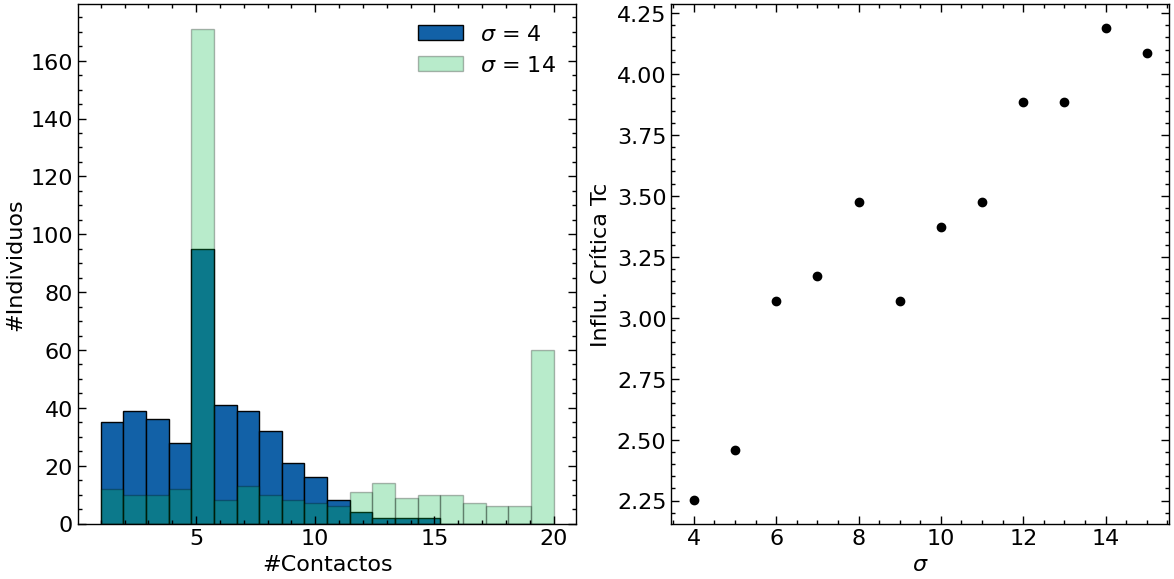

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N = 20
mu = 5

for sigma in [4, 14]:
    dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
    dist_lattice[dist_lattice<1] = mu
    dist_lattice[dist_lattice>N] = N
    _ = ax1.hist(dist_lattice.flatten(), range=(1, N), bins=20, edgecolor='k', alpha=3.9/sigma, label=r'$\sigma$ = '+str(sigma))
    ax1.set_ylabel('#Individuos')
    ax1.set_xlabel('#Contactos')
ax1.legend()
ax2.plot(sigma_arr, Tc_arr, 'ko')
# ax.set_xticks(list(range(0, 20+2, 2)))
ax2.set_xlabel(r'$\sigma$')
ax2.set_ylabel('Influ. Crítica Tc')
plt.tight_layout()
plt.show()

In [19]:
# fig.savefig('IMAGENES/gauss_Tc_din.png')

## Comparación del tamaño de los cúmulos
### $\nu$

In [10]:
@numba.njit(parallel=True, nogil=True)
def metropolis_cumulos_int(lattice, steps, T, num):
    """ funcion analoga a las ateriores de metropolis pero 
        en vez de devolver la opinion por individuo devuelve 
        la distribucion de la red despues de steps pasos de 
        montecarlo
    """
    lattice = lattice.copy()
    N = len(lattice)
    vecinos_dict = generate_vecinos_int(num, N)
    for step in prange(steps):
        # seleccionamos espin aleatorio para modificar contactos o para moificar espins
        x, y = np.random.randint(0, N, 2) 
        if step%2:
            spin_i = lattice[x, y]
            spin_f = -1*spin_i
            # calculo de la opinion de los 4 vecinos
            vecinos = vecinos_dict[x, y]
            # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
            # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
            S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
            # ver si se acepta el cambio
            if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
                # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
                # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
                # ponemos el valor absoluto para mantener el sentido del modelo de ising
                lattice[x, y] = spin_f
        else:
            vecinos_actuales = vecinos_dict[x, y]
            # choose random vecino to change
            num_vecinos = len(vecinos_actuales[0])
            change = np.random.randint(num_vecinos)
            x_change, y_change = vecinos_actuales[0][change], vecinos_actuales[1][change] 
            
            if lattice[x, y] * lattice[x_change, y_change] < 0:
                 # si no estan de acuerdo cambiamos ese vecino aleatoriamente
                x_f, y_f = np.random.randint(0, N, 2)
                while (x==x_f)*(y==y_f):
                    # evitar que se coja el mismo espin x0, y0
                    x_f, y_f = np.random.randint(0, N, 2)
                    
                # modificamos el diccionario de las conexiones
                vecinos_actuales[0][change] = x_f
                vecinos_actuales[1][change] = y_f
                vecinos_dict[x, y] = vecinos_actuales
                
            
    return lattice

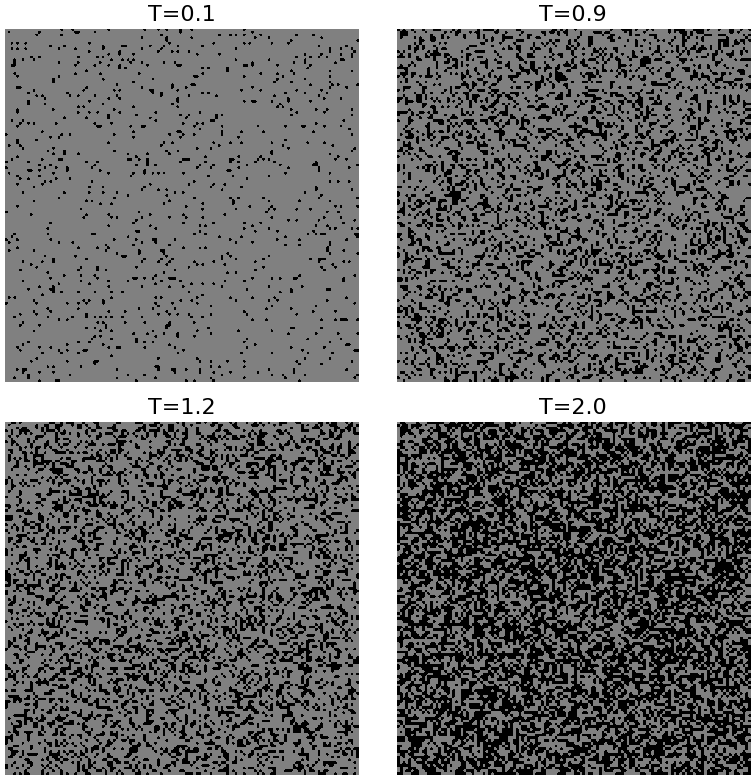

CPU times: total: 3.45 s
Wall time: 998 ms


In [31]:
%%time
# Tamaño promedio de los cumulos
N = int(2**7)
nu = 6
montecarlo_steps = 200000
T_arr = [.1, .9, 1.2, 2.]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, T, in enumerate(T_arr):
    lattice = init_poblacion(N, 0.5)
    lattice_final = metropolis_cumulos_int(lattice, montecarlo_steps, T, nu)
    plot_poblacion(lattice_final, axes.flatten()[i], cb=False)
    axes.flatten()[i].set_title(f'T={T}')
plt.tight_layout()
plt.show()

In [32]:
# fig.savefig('IMAGENES/tamaño_cumulo_int_din.png')

### Gauss

In [11]:
@numba.njit(parallel=True, nogil=True)
def metropolis_cumulos_array(lattice, steps, T, num):
    """ funcion analoga a las ateriores de metropolis pero 
        en vez de devolver la opinion por individuo devuelve 
        la distribucion de la red despues de steps pasos de 
        montecarlo
    """
    lattice = lattice.copy()
    N = len(lattice)
    vecinos_dict = generate_vecinos_array(num, N)
    for step in prange(steps):
        # seleccionamos espin aleatorio para modificar contactos o para moificar espins
        x, y = np.random.randint(0, N, 2) 
        if step%2:
            spin_i = lattice[x, y]
            spin_f = -1*spin_i
            # calculo de la opinion de los 4 vecinos
            vecinos = vecinos_dict[x, y]
            # vecinos proviene del diccionario creado a partir de generate_vecinos(x, y, num, N)
            # vecinos = (xv1, xv2, ...), (yv1, yv2, ...)
            S = sum([lattice[xv, yv] for xv, yv in zip(*vecinos)])
            # ver si se acepta el cambio
            if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
                # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
                # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
                # ponemos el valor absoluto para mantener el sentido del modelo de ising
                lattice[x, y] = spin_f
        else:
            vecinos_actuales = vecinos_dict[x, y]
            # choose random vecino to change
            num_vecinos = len(vecinos_actuales[0])
            change = np.random.randint(num_vecinos)
            x_change, y_change = vecinos_actuales[0][change], vecinos_actuales[1][change] 
            
            if lattice[x, y] * lattice[x_change, y_change] < 0:
                 # si no estan de acuerdo cambiamos ese vecino aleatoriamente
                x_f, y_f = np.random.randint(0, N, 2)
                while (x==x_f)*(y==y_f):
                    # evitar que se coja el mismo espin x0, y0
                    x_f, y_f = np.random.randint(0, N, 2)
                    
                # modificamos el diccionario de las conexiones
                vecinos_actuales[0][change] = x_f
                vecinos_actuales[1][change] = y_f
                vecinos_dict[x, y] = vecinos_actuales
                
            
    return lattice

In [24]:
N = int(2**7)
mu = 5
sigma = 14
dist_lattice = np.random.normal(mu, sigma, N*N).reshape((N, N)).astype('int')
dist_lattice[dist_lattice<1] = mu
dist_lattice[dist_lattice>N] = N

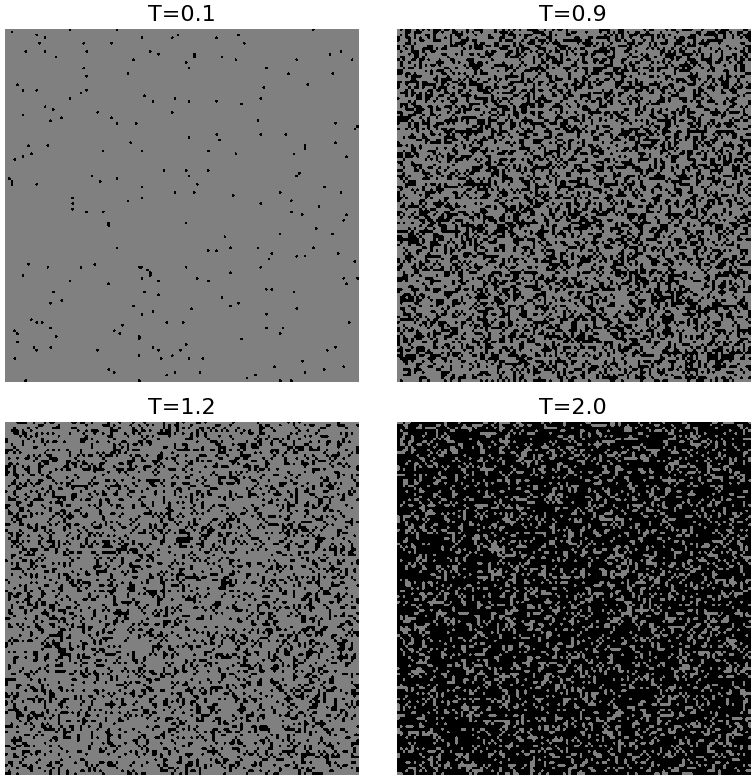

CPU times: total: 4.31 s
Wall time: 1.12 s


In [48]:
%%time
montecarlo_steps = 200000
T_arr = [.1, .9, 1.2, 2.]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, T, in enumerate(T_arr):
    lattice = init_poblacion(N, 0.5)
    lattice_final = metropolis_cumulos_array(lattice, montecarlo_steps, T, dist_lattice)
    plot_poblacion(lattice_final, axes.flatten()[i], cb=False)
    axes.flatten()[i].set_title(f'T={T}')
plt.tight_layout()
plt.show()

In [49]:
# fig.savefig('IMAGENES/tamaño_cumulo_array_din.png')